### Fine-Tuning CLIP Models (画像分類のためのCLIPモデルをファインチューニング)

GPUに設定

### **1. 関連ライブラリのインストール**

In [ ]:
# Stops output in Colab. Remove this if you wish.
%%capture

!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm   #tqdmはファインチューニングの進捗状況を追跡するために使用

### **2. データセットを読み込む**

ファインチューニングを行うために、小さな画像分類データセット（ファッション商品のコレクションである`ceyda/fashion-products-small`データセット）を使います。

In [ ]:
# Stops output in Colab. Remove this if you wish.
%%capture

from datasets import load_dataset

# Load the dataset
ds = load_dataset('ceyda/fashion-products-small')

このデータセットの特徴を見る

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image'],
        num_rows: 42700
    })
})

filename`、`link`、`id`、`masterCategory`、`gender`、`subCategory`、`image`があることがわかります。これらの特徴が何を意味するのか、このデータセットから最初の例を表示します。

In [ ]:
entry = ds['train'][0]
entry

{'filename': '15970.jpg',
 'link': 'http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg',
 'id': '15970',
 'masterCategory': 'Apparel',
 'gender': 'Men',
 'subCategory': 'Topwear',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>}

* `filename`: 画像のファイル名で画像がこの名前で保存または識別されていることを示す。
* `link`: オンラインでホストされている実際の画像ファイルへのURLリンクです。このリンクを使用して、画像を表示またはダウンロードすることができます。
* `id`: 画像の一意な識別子であり、データセット内で特定のアイテムを参照するために使われます。
* `masterCategory`: 製品が該当する大まかなカテゴリーを示します。
* `gender`: 男性用衣料品です。
* `subCategory`: マスターカテゴリーのより具体的なカテゴリーです。「トップウェア」は、シャツ、Tシャツ、ジャケットなど、上半身に着用する衣料品であることを示します。
* `image`: PIL(Python Imaging Library)画像オブジェクトで、画像の操作や処理ができます。画像モード（RGB、つまり赤、緑、青のカラーチャンネルを持つ）と画像サイズ（幅384ピクセル×高さ512ピクセル）を指定します。

画像を表示

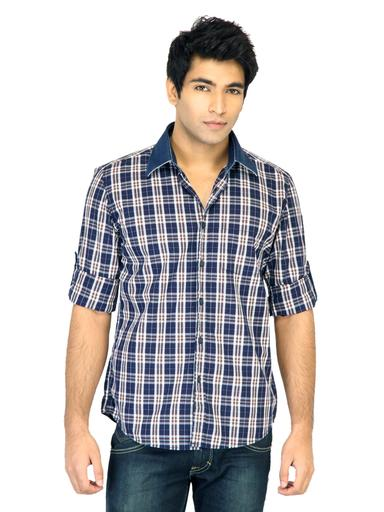

In [ ]:
image = entry['image']
image

メンズのトップウェアです。

データセットを以下のように定義します。

In [ ]:
dataset = ds['train']

### **3. CLIPモデルの読み込みと前処理**

CLIPモデル（`ViT-B/32`）とその前処理機能が読み込まれます。モデルは適切なデバイス（GPUがあればGPU、なければCPU）に移動されます。

In [ ]:
# Stops output in Colab. Remove this if you wish.
%%capture

import clip
import torch

# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIPモデルを用い、データセットから3つの画像例を、その視覚的特徴とサブカテゴリのテキスト記述を比較することで分類します。画像とサブカテゴリのテキストの特徴を処理して正規化し、それらの類似度を計算し、各画像のサブカテゴリを予測します。最後に、予測されたサブカテゴリと実際のサブカテゴリをプロットして画像を可視化します。

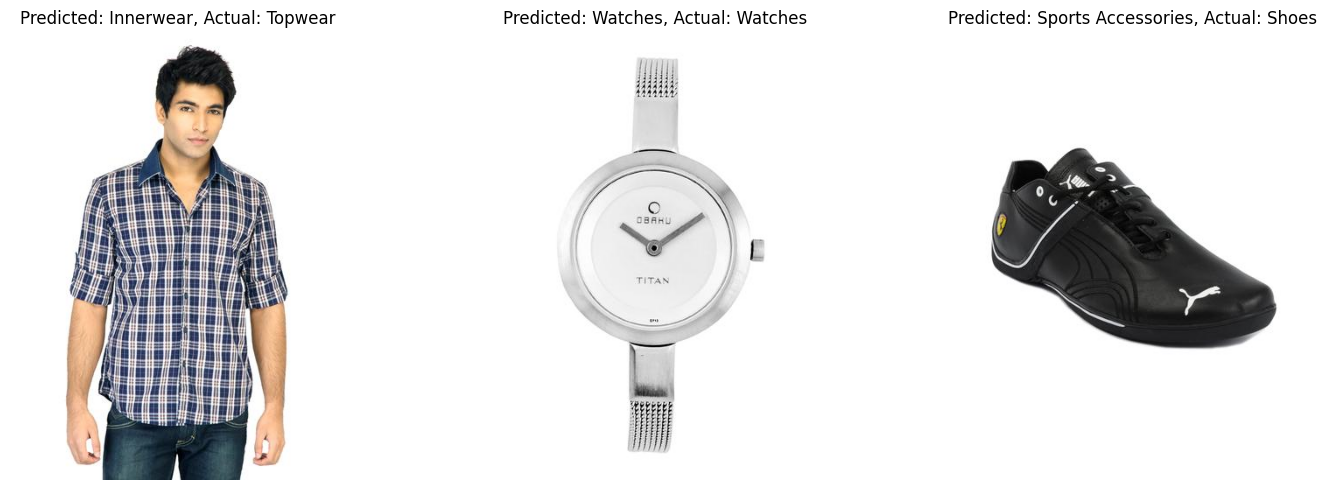

In [ ]:
import matplotlib.pyplot as plt

# Select indices for three example images
indices = [0, 2, 10]

# Get the list of possible subcategories from the dataset
subcategories = list(set(example['subCategory'] for example in dataset))

# Preprocess the text descriptions for each subcategory
text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in subcategories]).to(device)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Select an example image from the dataset
    example = dataset[idx]
    image = example['image']
    subcategory = example['subCategory']

    # Preprocess the image
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Calculate image and text features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity between image and text features
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {subcategories[indices[0]]}, Actual: {subcategory}")
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

3つの画像を見てわかるように、CLIPモデルはあまりうまく機能していません。3つの画像のうち正しく識別できたのは1つだけです。

これらの予測を改善するためにCLIPモデルをファインチューニングする手順を設定します。

### **4. データセットの加工**

データセットを訓練セットと検証セット（80%を訓練、20%を検証）に分けます。

In [ ]:
from torch.utils.data import random_split

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

カスタム・データセット・クラスを作成します。

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset

# Define a custom dataset class
class FashionDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        subcategory = item['subCategory']
        label = subcategories.index(subcategory)
        return self.transform(image), label

* **`__init__` method**: データセットオブジェクトをデータで初期化し、画像を前処理するための一連の変換を設定します。変換には、画像を224x224ピクセルにリサイズすること、テンソルに変換すること、特定の平均値と標準偏差値で正規化することなどが含まれます。
* **`__len__` method**: データセットのサンプル数を返します。
* **`__getitem__` method**: データセットから画像とそれに対応するサブカテゴリを取り出します。画像は定義済みの変換を使用して変換され、サブカテゴリはサブカテゴリリスト内のインデックスを見つけることでラベルに変換されます。

DataLoadersを作成します。

In [ ]:
from torch.utils.data import DataLoader

# Create DataLoader for training and validation sets
train_loader = DataLoader(FashionDataset(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(FashionDataset(val_dataset), batch_size=32, shuffle=False)

* `train_loader`: バッチサイズは32とし、サンプルの順序をランダムにするシャッフリングが有効としたトレーニングセット用のDataLoader
* `val_loader`: バッチサイズを32とし、サンプルの順序を維持するためにシャッフルを無効とした検証セット用のDataLoader

ファインチューニングのためにモデルを修正します。

In [ ]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

* **`__init__` method**: CLIPモデルとサブカテゴリ用の新しい線形分類器でファインチューニングモデルを初期化します。線形層は `num_classes` の出力ユニットを持ち、これはサブカテゴリの数に対応します。
* **`forward` method**: 入力画像をCLIPモデルに通して特徴を抽出し（ベースモデルの重みは更新しない）、次に新しい分類器に通してサブカテゴリを予測します。

ファインチューニングモデルをインスタンス化します。

In [ ]:
num_classes = len(subcategories)
model_ft = CLIPFineTuner(model, num_classes).to(device)

* `num_classes`: データセット内のユニークなサブカテゴリーの数
* `model_ft`: CLIPFineTunerクラスのインスタンスで、サブカテゴリー分類タスクのファイナチューニング用にセットアップされ、指定されたデバイス（CPUまたはGPU）に移動します。

ファインチューニングに必要なものはすべてセットアップしました。次に損失関数とオプティマイザを定義します。

### **5. 損失関数とオプティマイザの定義**

In [ ]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

* `criterion`: 使用される損失関数はクロスエントロピー損失で、多クラス分類タスクに適しています。
* `optimizer`: 使用されるオプティマイザはアダムで、分類器層のパラメータ（model_ft.classifier.parameters()）にのみ適用され、学習率は0.0001です。

### **6. CLIPモデルのファインチューニング**

**Training:**

* `num_epochs`: エポック数（学習データセット全体に対する反復回数）を指定
* Training mode: モデルは `model_ft.train()` を用いてトレーニングモードに設定
* Progress bar: プログレスバー（`tqdm`）はトレーニングループの進行状況を追跡するために使用され、現在のエポックと実行中の損失を表示
* Training steps:
  - `train_loader`からの画像とラベルの各バッチについて:
    - 画像とラベルを指定されたデバイス（CPUまたはGPU）に移動
    - `optimizer.zero_grad()`を使ってグラデーションをゼロにする
    - Forward pass: モデルの出力を計算
    - 基準を用いて損失を計算
    - Backward pass: `loss.backward()`を使って勾配を計算
    - `optimizer.step()`を使ってモデルのパラメーターを更新
    - ランニングロスの更新
    - プログレスバーの説明をエポックの平均損失で更新
- 各エポックの後、そのエポックの平均損失が表示

**Validation:**
- Evaluation mode: モデルは `model_ft.eval()` を用いて評価モードに設定
- Accuracy calculation:
  - `torch.no_grad()`で勾配計算を無効
  - val_loaderからの画像とラベルの各バッチについて:
    - 画像とラベルを指定されたデバイスに移動
    - Forward pass: モデルの出力を計算
    - `torch.max`を使って最もスコアの高いクラスを見つけ予測ラベルを取得
    - ラベルの総数と予測の正解数を更新
  - 検証精度をパーセントで計算し表示

**Save the Fine-Tuned Model:**
ファインチューニングされたモデルのステート辞書は`'clip_finetuned.pth'`という名前のファイルに保存

In [ ]:
from tqdm import tqdm

# Number of epochs for training
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    print(f'Validation Accuracy: {100 * correct / total}%')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

Epoch 1/5, Loss: 1.5540: 100%|██████████| 1068/1068 [03:09<00:00,  5.64it/s]


Epoch [1/5], Loss: 1.5540
Validation Accuracy: 84.89461358313817%


Epoch 2/5, Loss: 0.5767: 100%|██████████| 1068/1068 [03:04<00:00,  5.79it/s]


Epoch [2/5], Loss: 0.5767
Validation Accuracy: 90.6791569086651%


Epoch 3/5, Loss: 0.3811: 100%|██████████| 1068/1068 [03:02<00:00,  5.86it/s]


Epoch [3/5], Loss: 0.3811
Validation Accuracy: 92.06088992974239%


Epoch 4/5, Loss: 0.2997: 100%|██████████| 1068/1068 [03:02<00:00,  5.86it/s]


Epoch [4/5], Loss: 0.2997
Validation Accuracy: 92.82201405152225%


Epoch 5/5, Loss: 0.2558: 100%|██████████| 1068/1068 [03:02<00:00,  5.84it/s]


Epoch [5/5], Loss: 0.2558
Validation Accuracy: 93.4192037470726%


結果が示すように、ファインチューニングは成功し、モデルはエポックにわたってトレーニング損失と検証精度の両方で大幅な改善を示しています。最終的な検証精度は93.41%で、モデルがトレーニングデータから効果的に学習し、検証データでも良好なパフォーマンスを示しています。訓練損失が徐々に減少し、検証精度が着実に向上していることは、オーバーフィッティングやアンダーフィッティングの兆候がなく、訓練プロセスが適切に行われたことを反映しています。

先ほどテストしたのと同じ画像で、新モデルがどのような性能を発揮するか見てみます。

<ipython-input-16-9e649c00c9fc>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load('clip_finetuned.pth'))


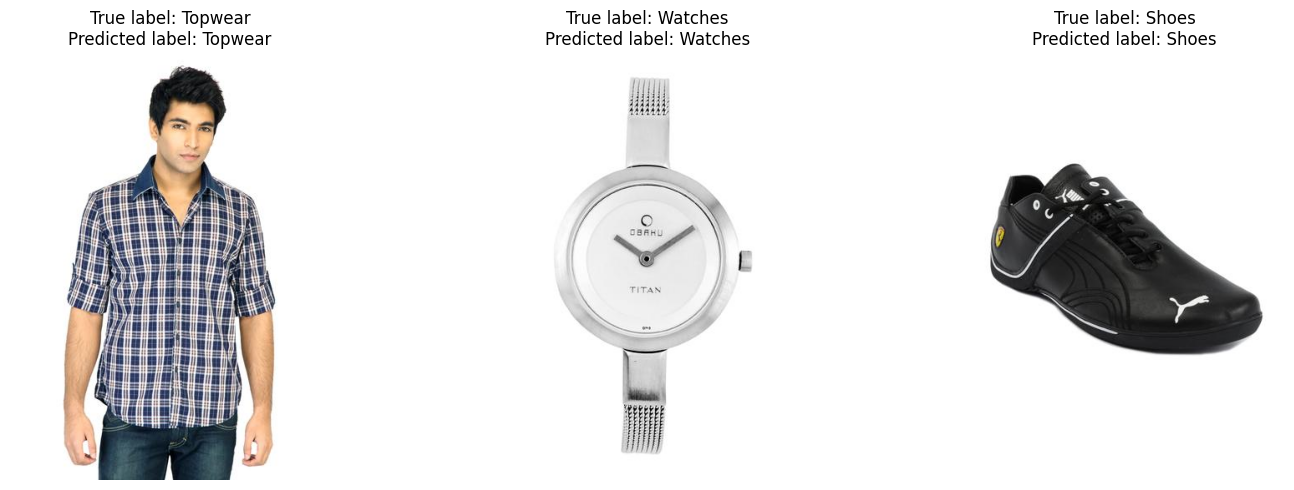

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Load the saved model weights
model_ft.load_state_dict(torch.load('clip_finetuned.pth'))
model_ft.eval()  # Set the model to evaluation mode

# Define the indices for the three images
indices = [0, 2, 10]

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Get the image and label from the dataset
    item = dataset[idx]
    image = item['image']
    true_label = item['subCategory']

    # Transform the image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = subcategories[predicted_label_idx.item()]

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

新たにファインチューニングされたCLIPモデルは、3つの画像のラベルを予測することに成功しました。